# Memory: A Cognitive Modeling Perspective

From a modelling stand-point, different types of memory are not super well-defined at a psychological level.

For the purposes of this lecture, we're just going to focus on time-frame:
- Long-term memory *(t > days)*
- Short-term or working memory *(t < a few minutes)*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
import nengo.spa as spa

# Short-Term: Integrators

Previously showed how integrators could save a scalar.

In [20]:
dimensions = 3
n_neurons = 50

feedback = 1.0
feedback_synapse = 0.1

model = nengo.Network("integrator mem")
with model:
    inp = nengo.Node([0, 0, 0])
    reset = nengo.Node([0])
    state = nengo.networks.EnsembleArray(50, dimensions)
    state.add_neuron_input()
    
    nengo.Connection(inp, state.input)
    nengo.Connection(state.output, state.input, transform=feedback, synapse=feedback_synapse)
    nengo.Connection(reset, state.neuron_input, transform=-3*np.ones((n_neurons*dimensions, 1)))

In [22]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/integ_mem.py.cfg")

**Note**: you can [engineer a working memory even further](https://github.com/nengo/nengo/blob/master/nengo/networks/workingmemory.py), by essentially making a flip-flop in neurons. This is not necessary for this tutorial.

A SPA pointer is just a vector of scalars, so a memory can be an array of integrators.

In [2]:
dimensions = 32
vocab = spa.Vocabulary(dimensions)
vocab.parse("CIRCLE+BLUE+SQUARE+RED")

model = spa.SPA(vocabs=[vocab], label="Simple question answering")

with model:
    model.color_in = spa.State(dimensions=dimensions)
    model.shape_in = spa.State(dimensions=dimensions)
    model.conv = spa.State(dimensions=dimensions,
                           neurons_per_dimension=100,
                           feedback=1,
                           feedback_synapse=0.4)
    model.cue = spa.State(dimensions=dimensions)
    model.out = spa.State(dimensions=dimensions)

    # Connect the state populations
    cortical_actions = spa.Actions(
        'conv = color_in * shape_in',
        'out = conv * ~cue'
    )
    model.cortical = spa.Cortical(cortical_actions)

In [3]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/mem_q.py.cfg")

## Further Reading

- Integrator-based memories to model list memorisation [Choo et al. 2010](http://compneuro.uwaterloo.ca/publications/choo2010a.html)
- Approximating the delay function on a recurrent connection to model temporal memory [Voelker et al. 2018](http://compneuro.uwaterloo.ca/publications/voelker2018.html)
- Creating a stack-like memory in neurons for action planning [Blouw et al. 2016](http://compneuro.uwaterloo.ca/publications/Blouw2016.html)

# Long-Term: Cleanup and Associative Memories

The result of an unbinding operation is a noisy result. If this result is going to be used, you often want to clean it up.

Cleanup memories are based on the same idea the Basal Ganglia uses. Each population of neurons is a pointer symbol, rather than an action. However, you still only want one symbol to be output.

But a cleanup memory works under fewer constraints. It doesn't need to scale to hundreds of highly similar pointers, so it can trade scale and robustness for response speed.

If you want to instead output a different pointer instead of just cleaning up the input pointer, you just apply a weight transform on the output.

In [45]:
def plot_similarities(input_data,
                      output_data,
                      vocab1,
                      vocab2=None,
                      autoscale=False):
    if vocab2 is None:
        vocab2 = vocab1

    ymin, ymax = -1.2, 1.2
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.plot(t, spa.similarity(input_data, vocab1))
    plt.title("Input similarity")
    plt.xlabel("Time")
    plt.xlim(right=t[-1])
    plt.legend(
        vocab1.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

    plt.subplot(1, 2, 2)
    plt.plot(t, spa.similarity(output_data, vocab2))
    plt.title("Output similarity")
    plt.xlabel("Time")
    plt.xlim(right=t[-1])
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.legend(
        vocab2.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)
    plt.tight_layout()

In [24]:
dim = 16
vocab_numbers = spa.Vocabulary(dimensions=dim)

# a quicker way to add words to a vocabulary
vocab_numbers.parse('ONE + TWO + THREE + FOUR + FIVE')

In [25]:
# example using nengo.spa
def input_fun(t):
    if t < 0.2:
        return 'ONE'
    elif t < 0.4:
        return 'TWO'
    elif t < 0.6:
        return 'THREE'
    elif t < 0.8:
        return 'FOUR'
    else:
        return '0'


# from patterns
input_keys = ['ONE', 'TWO', 'THREE', 'FOUR']

# to patterns
output_keys = ['TWO', 'THREE', 'FOUR', 'FIVE']

with spa.SPA('Counting', seed=1) as model:
    model.assoc_mem = spa.AssociativeMemory(
        input_vocab=vocab_numbers,
        output_vocab=vocab_numbers,
        input_keys=input_keys,
        output_keys=output_keys,
        wta_output=True)

    model.am_input = spa.Input(assoc_mem=input_fun)

    input_probe = nengo.Probe(model.assoc_mem.input)
    output_probe = nengo.Probe(model.assoc_mem.output, synapse=0.03)

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(1.)
t = sim.trange()

input_data = sim.data[input_probe]
output_data = sim.data[output_probe]

plot_similarities(input_data, output_data, vocab_numbers, autoscale=True)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:01.                                                                              


NameError: name 'plot_similarities' is not defined

In [26]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_count.py.cfg")

**Note**: If you look at the internals of the memory, you'll find a "bias node", because it's easier to modify a bias than change neuron intercepts for the purposes of optimization. Looking inside a network and finding something slightly different than you expected for optimisation reasons is a typical experience in Nengo.

## Learning Memories

Can we learn a network to perform cleanup and association using PES?

In [9]:
num_items = 5

d_key = 2
d_value = 2

rng = np.random.RandomState(seed=7)
keys = nengo.dists.UniformHypersphere(surface=True).sample(
    num_items, d_key, rng=rng)
values = nengo.dists.UniformHypersphere(surface=False).sample(
    num_items, d_value, rng=rng)

In [10]:
def cycle_array(x, period, dt=0.001):
    """Cycles through the elements"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        return x[int(i / i_every) % len(x)]

    return f

In [13]:
# Model constants
n_neurons = 200
dt = 0.001
period = 0.3
T = period * num_items * 2

# Model network
model = nengo.Network()
with model:

    # Create the inputs/outputs
    stim_keys = nengo.Node(output=cycle_array(keys, period, dt))
    stim_values = nengo.Node(output=cycle_array(values, period, dt))
    learning = nengo.Node(output=lambda t: -int(t >= T / 2))
    recall = nengo.Node(size_in=d_value)

    # Create the memory
    memory = nengo.Ensemble(
        n_neurons, d_key)

    conn_in = nengo.Connection(
        stim_keys, memory, synapse=None)

    # Learn the decoders/values, initialized to a null function
    conn_out = nengo.Connection(
        memory,
        recall,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d_value))

    # Create the error population
    error = nengo.Ensemble(n_neurons, d_value)
    nengo.Connection(
        learning, error.neurons, transform=[[10.0]] * n_neurons, synapse=None)

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(stim_values, error, transform=-1, synapse=None)
    nengo.Connection(recall, error, synapse=None)
    nengo.Connection(error, conn_out.learning_rule)

    # Setup probes
    p_keys = nengo.Probe(stim_keys, synapse=None)
    p_values = nengo.Probe(stim_values, synapse=None)
    p_learning = nengo.Probe(learning, synapse=None)
    p_error = nengo.Probe(error, synapse=0.005)
    p_recall = nengo.Probe(recall, synapse=None)

In [14]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)
t = sim.trange()

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:02.                                                                              


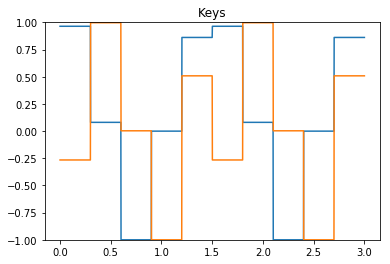

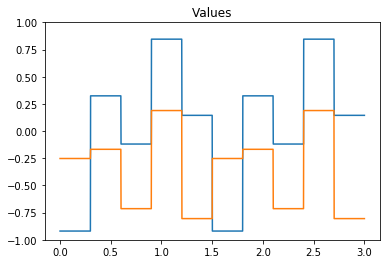

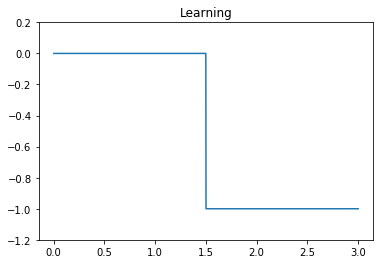

In [15]:
plt.figure()
plt.title("Keys")
plt.plot(t, sim.data[p_keys])
plt.ylim(-1, 1)

plt.figure()
plt.title("Values")
plt.plot(t, sim.data[p_values])
plt.ylim(-1, 1)

plt.figure()
plt.title("Learning")
plt.plot(t, sim.data[p_learning])
plt.ylim(-1.2, 0.2);

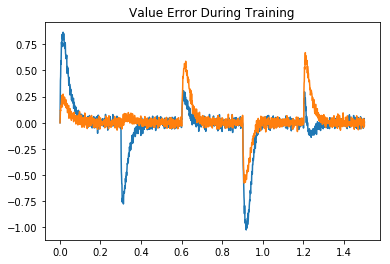

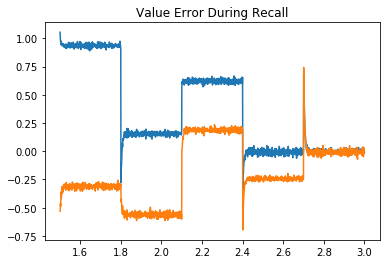

In [16]:
train = t <= T / 2
test = ~train

plt.figure()
plt.title("Value Error During Training")
plt.plot(t[train], sim.data[p_error][train])

plt.figure()
plt.title("Value Error During Recall")
plt.plot(t[test], sim.data[p_recall][test] - sim.data[p_values][test]);

PES is proportional to the neurons spiking, but if a neuron is spiking for a bunch of inputs, the decoders of the neuron never converge.

Let's change the encoders so the neurons are more selective.

In [30]:
intercepts = [0.7] * n_neurons
encoders = []

for n_i in range(n_neurons):
    k_i = n_i%len(keys)
    tmp_enc = keys[k_i] + np.random.normal(0, 0.1, size=2)
    encoders.append(tmp_enc / np.linalg.norm(tmp_enc))

encoders = np.array(encoders)

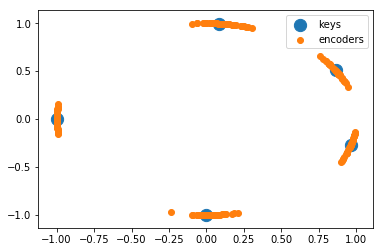

In [31]:
plt.scatter(keys[:, 0], keys[:, 1], s=150, label="keys")
plt.scatter(enc[:, 0], enc[:, 1], label="encoders")
plt.legend()

In [35]:
# Model network
model = nengo.Network()
with model:

    # Create the inputs/outputs
    stim_keys = nengo.Node(output=cycle_array(keys, period, dt))
    stim_values = nengo.Node(output=cycle_array(values, period, dt))
    learning = nengo.Node(output=lambda t: -int(t >= T / 2))
    recall = nengo.Node(size_in=d_value)

    # Create the memory
    memory = nengo.Ensemble(
        n_neurons, d_key, intercepts=intercepts, encoders=encoders)

    conn_in = nengo.Connection(
        stim_keys, memory, synapse=None)

    # Learn the decoders/values, initialized to a null function
    conn_out = nengo.Connection(
        memory,
        recall,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d_value))

    # Create the error population
    error = nengo.Ensemble(n_neurons, d_value)
    nengo.Connection(
        learning, error.neurons, transform=[[10.0]] * n_neurons, synapse=None)

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(stim_values, error, transform=-1, synapse=None)
    nengo.Connection(recall, error, synapse=None)
    nengo.Connection(error, conn_out.learning_rule)

    # Setup probes
    p_keys = nengo.Probe(stim_keys, synapse=None)
    p_values = nengo.Probe(stim_values, synapse=None)
    p_learning = nengo.Probe(learning, synapse=None)
    p_error = nengo.Probe(error, synapse=0.005)
    p_recall = nengo.Probe(recall, synapse=None)

In [36]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)
t = sim.trange()

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:02.                                                                              


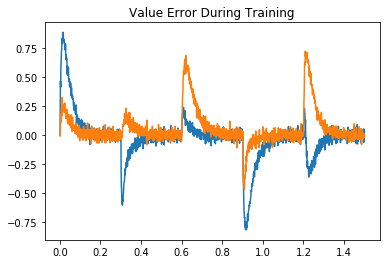

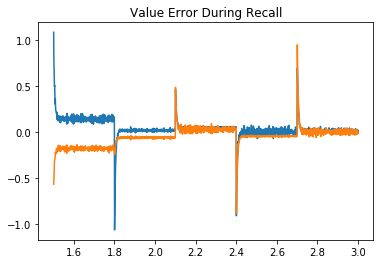

In [37]:
train = t <= T / 2
test = ~train

plt.figure()
plt.title("Value Error During Training")
plt.plot(t[train], sim.data[p_error][train])

plt.figure()
plt.title("Value Error During Recall")
plt.plot(t[test], sim.data[p_recall][test] - sim.data[p_values][test]);

But this assumes our memory knows all the vocabulary ahead of time. Can we learn the encoders instead?

### Voja

Voja: Vector Oja [Voelker et al. 2016](http://compneuro.uwaterloo.ca/publications/voelker2016b.html)

$$
\Delta e_i = \kappa a_i (x - e_i)
$$

where $e_i$ is the encoder of the $i^{th}$ neuron, $\kappa$ is a modulatory learning rate (positive to move towards, and negative to move away), $a_i$ is the filtered activity of the $i^{th}$ neuron, and $x$ is the input vector encoded by each neuron.

In [38]:
# Model network
model = nengo.Network()
with model:

    # Create the inputs/outputs
    stim_keys = nengo.Node(output=cycle_array(keys, period, dt))
    stim_values = nengo.Node(output=cycle_array(values, period, dt))
    learning = nengo.Node(output=lambda t: -int(t >= T / 2))
    recall = nengo.Node(size_in=d_value)

    # Create the memory
    memory = nengo.Ensemble(
        n_neurons, d_key, intercepts=intercepts)

    # Learn the encoders/keys
    voja = nengo.Voja(post_tau=None, learning_rate=5e-2)
    conn_in = nengo.Connection(
        stim_keys, memory, synapse=None, learning_rule_type=voja)
    nengo.Connection(learning, conn_in.learning_rule, synapse=None)

    # Learn the decoders/values, initialized to a null function
    conn_out = nengo.Connection(
        memory,
        recall,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d_value))

    # Create the error population
    error = nengo.Ensemble(n_neurons, d_value)
    nengo.Connection(
        learning, error.neurons, transform=[[10.0]] * n_neurons, synapse=None)

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(stim_values, error, transform=-1, synapse=None)
    nengo.Connection(recall, error, synapse=None)
    nengo.Connection(error, conn_out.learning_rule)

    # Setup probes
    p_keys = nengo.Probe(stim_keys, synapse=None)
    p_values = nengo.Probe(stim_values, synapse=None)
    p_learning = nengo.Probe(learning, synapse=None)
    p_error = nengo.Probe(error, synapse=0.005)
    p_recall = nengo.Probe(recall, synapse=None)
    p_encoders = nengo.Probe(conn_in.learning_rule, 'scaled_encoders')

In [39]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)
t = sim.trange()

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:02.                                                                              


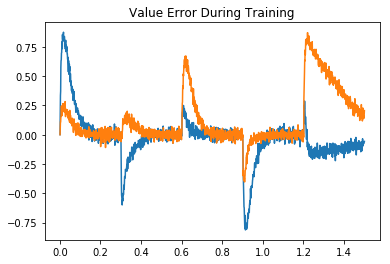

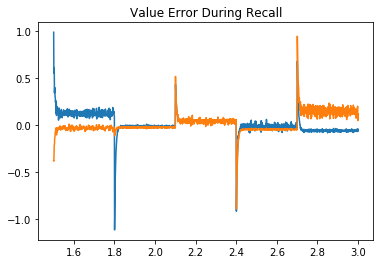

In [40]:
train = t <= T / 2
test = ~train

plt.figure()
plt.title("Value Error During Training")
plt.plot(t[train], sim.data[p_error][train])

plt.figure()
plt.title("Value Error During Recall")
plt.plot(t[test], sim.data[p_recall][test] - sim.data[p_values][test]);

C:\tools\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


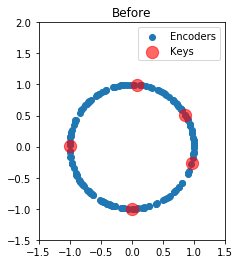

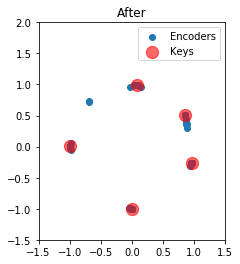

In [41]:
scale = (sim.data[memory].gain / memory.radius)[:, np.newaxis]


def plot_2d(text, xy):
    plt.figure()
    plt.title(text)
    plt.scatter(xy[:, 0], xy[:, 1], label="Encoders")
    plt.scatter(
        keys[:, 0], keys[:, 1], c='red', s=150, alpha=0.6, label="Keys")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 2)
    plt.legend()
    plt.axes().set_aspect('equal')


plot_2d("Before", sim.data[p_encoders][0].copy() / scale)
plot_2d("After", sim.data[p_encoders][-1].copy() / scale)

What happens if the intercepts aren't set?

## Further Reading

- Alternative Associative Memory architectures optimising for different criteria [Gosmann et al. 2017](http://compneuro.uwaterloo.ca/publications/gosmann2017a.html)
- Scaling up Associative Memories to large corpuses [Kajic et al. 2017](http://compneuro.uwaterloo.ca/publications/kajic2017.html)

# Short-Term to Long-Term

After the break!